In [ ]:
import geopandas as gpd
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import cbsodata

import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from pysal.model import spreg

# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily
from pysal.lib import weights
from pysal.explore import esda
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn
import contextily

# Analysis
import geopandas
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Load files

In [ ]:
# load calculated vgvi for the entire NED file
vgvi = gpd.read_file('ned_vgvi.gpkg')
vgvi = vgvi.drop(columns=['id']) # drop duplicated index 
vgvi.head()

In [ ]:
# obtain data on socio-economic indicators from cbs 
# gdf_cbs = pd.DataFrame(cbsodata.get_data('85039NED')) # obtain the data from cbs 2021
# gdf_cbs_20 = pd.DataFrame(cbsodata.get_data('84799NED')) # obtain the data from cbs 2021
# gdf_cbs.to_csv('data_collection/gdf_cbs.csv', index=False) # save the data locally
# gdf_cbs_20.to_csv('data_collection/gdf_cbs_20.csv', index=False) # save the data locally

gdf_cbs = pd.read_csv('data_collection/gdf_cbs.csv')
gdf_cbs_20 = pd.read_csv('data_collection/gdf_cbs_20.csv')

In [ ]:
# load burt and wijk files with polygons for later merge 
gdf_buurt = gpd.read_file("data_collection/income_data/WijkBuurtkaart_2022_v1/buurt_2022_v1.shp")
gdf_wijk = gpd.read_file("data_collection/income_data/WijkBuurtkaart_2022_v1/wijk_2022_v1.shp")

# Data preprocessing

In [ ]:
# gdf_cbs.to_csv('cbs_data.csv', index=False)

In [6]:
rename_dict = {'SoortRegio_2': 'type',
               'k_0Tot15Jaar_8': 'age_0_15',
                'k_15Tot25Jaar_9': 'age_15_25',
                'k_25Tot45Jaar_10': 'age_25_45',
                'k_45Tot65Jaar_11': 'age_45_65',
                'k_65JaarOfOuder_12': 'age_65_older',
               'Gemeentenaam_1': 'Gemeentenaam',
               'Codering_3': 'code',
                'Mannen_6': 'population',
               'WestersTotaal_17': 'western_background',
               'NietWestersTotaal_18': 'non_western_background',
               'GeboorteRelatief_25': 'birth_rate_1000',
               'SterfteRelatief_27': 'mortality_1000',
               'GemiddeldeHuishoudensgrootte_32': 'avg_household_size',
               'Bevolkingsdichtheid_33': 'population_density',
               'GemiddeldeWOZWaardeVanWoningen_35': 'avg_values_home',
               'GemiddeldElektriciteitsverbruikTotaal_47': 'avg_eletricity_cons',
               'GemiddeldAardgasverbruikTotaal_55': 'avg_nat_gas_cons',
               'Huurwoning_61': 'rental_home',
               'EigenWoning_62': 'non_rental_home',
               'OpleidingsniveauLaag_64': 'educ_low',
               'OpleidingsniveauMiddelbaar_65': 'educ_secondary',
               'OpleidingsniveauHoog_66': 'educ_high',
               'BedrijfsvestigingenTotaal_91': 'companies_total',
               'PersonenautoSPerHuishouden_103': 'cars_per_household',
               'MateVanStedelijkheid_116': 'degree_urbanity',
               'AantalInkomensontvangers_70': 'income_recipients_total',
               'GemiddeldInkomenPerInwoner_72': 'avg_income_inhabitant',
               'GemiddeldInkomenPerInkomensontvanger_71': 'avg_income_recipient',  
               'GemGestandaardiseerdInkomenVanHuish_75': 'avg_income_stand_household_1000'
}

columns_to_keep = ['WijkenEnBuurten']  # columns not to be changed but included

# rename and filter columns
gdf_cbs_filtered = gdf_cbs.copy()
gdf_cbs_filtered = gdf_cbs_filtered.rename(columns=rename_dict)  # rename specified columns
gdf_cbs_filtered = gdf_cbs_filtered[list(columns_to_keep) + list(rename_dict.values())]

<Axes: >

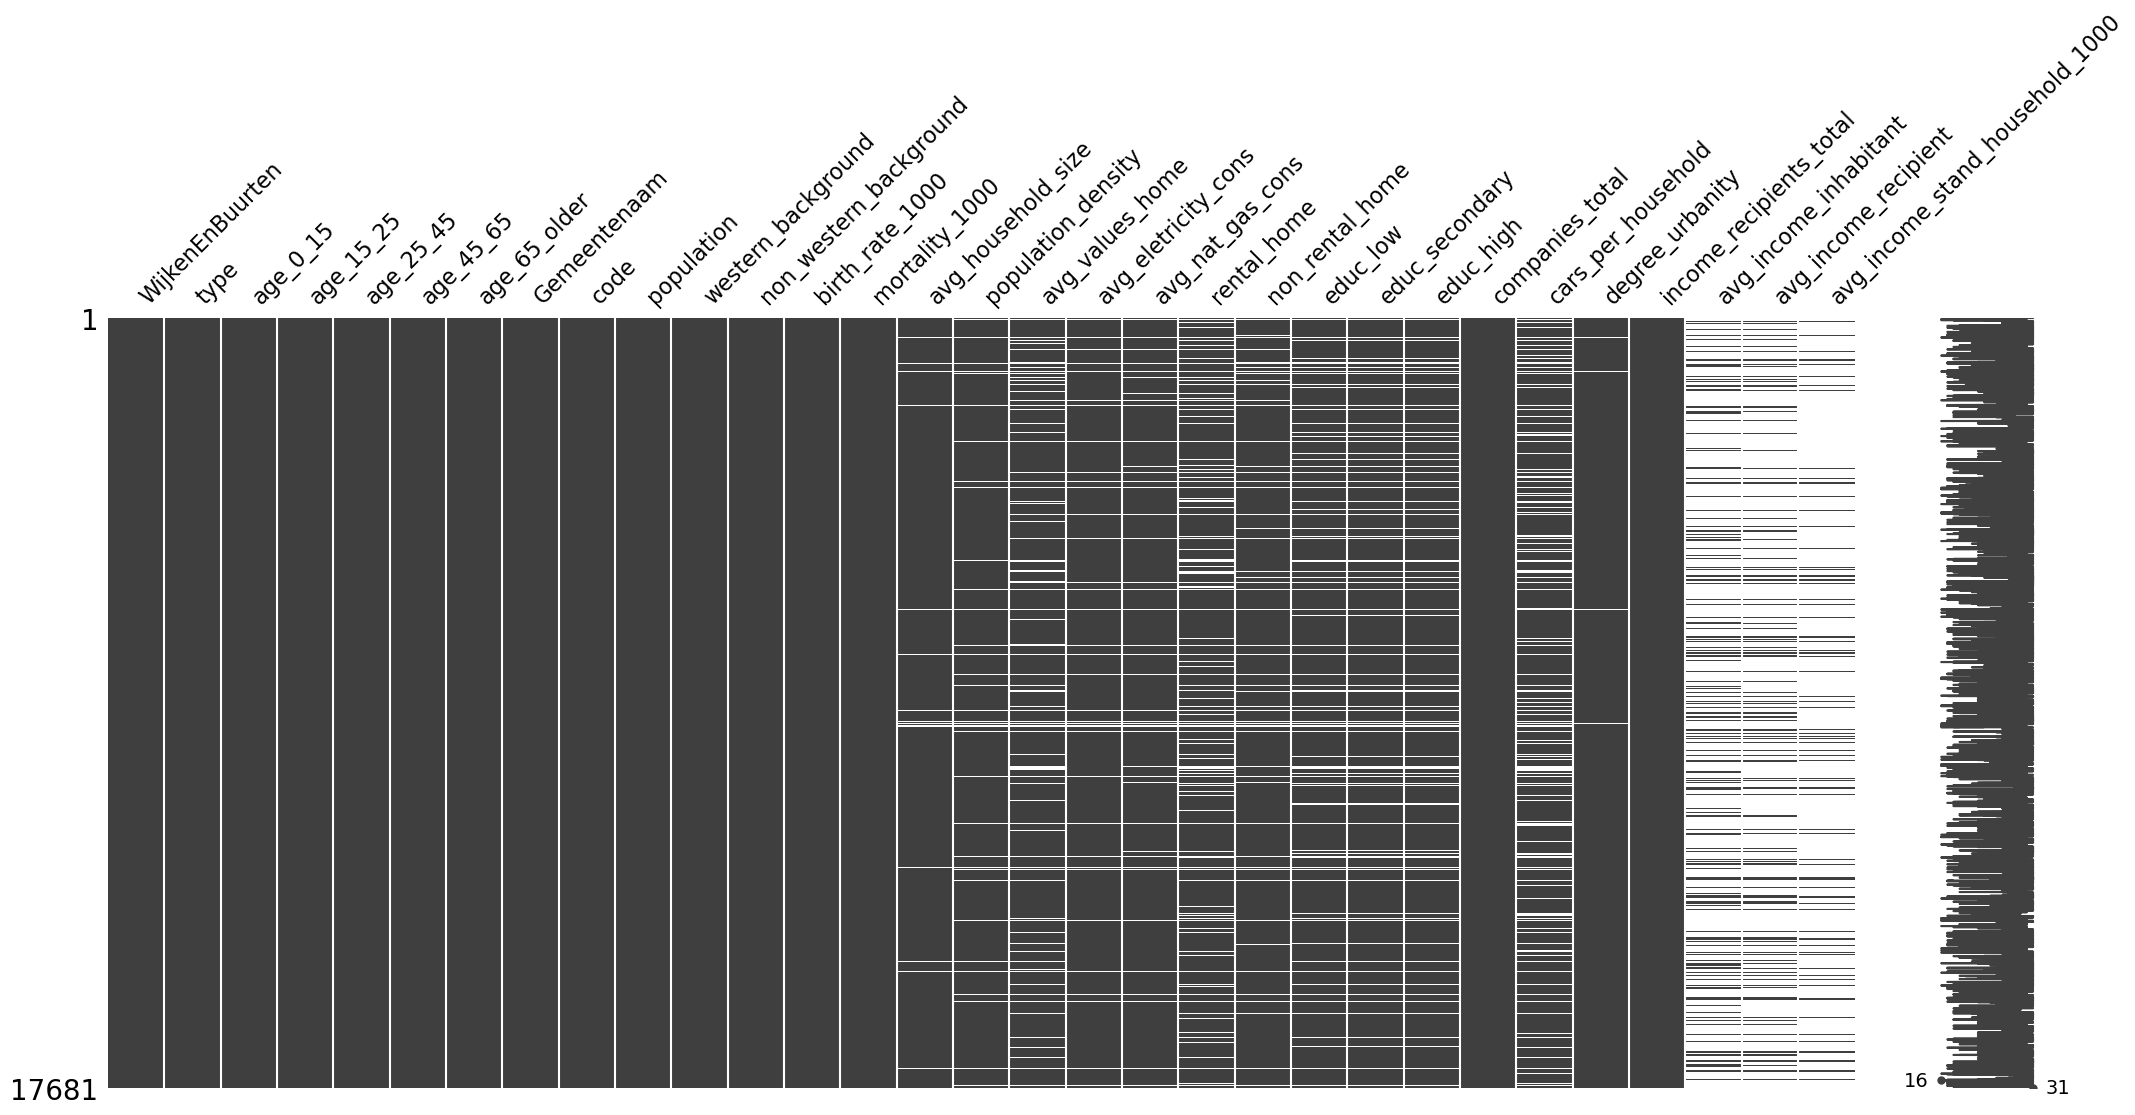

In [7]:
# check missingness
msno.matrix(gdf_cbs_filtered)

In [9]:
# chech number of missing values per column 
missing_values = gdf_cbs_filtered.isnull().sum()
print(missing_values)

WijkenEnBuurten                        0
type                                   0
age_0_15                               0
age_15_25                              0
age_25_45                              0
age_45_65                              0
age_65_older                           0
Gemeentenaam                           0
code                                   0
population                             0
western_background                     0
non_western_background                 0
birth_rate_1000                        0
mortality_1000                         0
avg_household_size                   373
population_density                   716
avg_values_home                     1989
avg_eletricity_cons                  941
avg_nat_gas_cons                    1011
rental_home                         2828
non_rental_home                     1285
educ_low                            2164
educ_secondary                      2158
educ_high                           2162
companies_total 

In [10]:
# calculate average age based on weighted category by the midpoint
age_columns = ['age_0_15', 'age_15_25', 'age_25_45', 'age_45_65', 'age_65_older']
gdf_cbs_filtered.drop('population', axis=1, inplace=True) # delete current population column, the given column had errors only 8686536 people for the Netherlands 
gdf_cbs_filtered['population'] = gdf_cbs_filtered[age_columns].sum(axis=1) # add new column based on age groups

weights = [7.5, 20, 35, 55, 75] # weights based on midpoints 
gdf_cbs_filtered['average_age'] = gdf_cbs_filtered[age_columns].mul(weights).sum(axis=1) / gdf_cbs_filtered[age_columns].sum(axis=1)

# drop old columns
gdf_cbs_filtered = gdf_cbs_filtered.drop(columns=age_columns)

# create new columns for background based on their proprotions of total population 
gdf_cbs_filtered['western_percentage'] = (gdf_cbs_filtered['western_background'] / gdf_cbs_filtered['population']) * 100
gdf_cbs_filtered['non_western_percentage'] = (gdf_cbs_filtered['non_western_background'] / gdf_cbs_filtered['population']) * 100
# remove old columns
gdf_cbs_filtered = gdf_cbs_filtered.drop(['western_background', 'non_western_background'], axis=1)

# create a single column of percentage of people with higher education 
gdf_cbs_filtered['higher_educ'] = (gdf_cbs_filtered['educ_high'] / gdf_cbs_filtered['population']) * 100
gdf_cbs_filtered = gdf_cbs_filtered.drop(['educ_low', 'educ_secondary', 'educ_high'], axis=1)

gdf_cbs_filtered.head()

WijkenEnBuurten        type  \
0                Nederland  Land         
1              Aa en Hunze  Gemeente     
2            Wijk 00 Annen  Wijk         
3                    Annen  Buurt        
4  Verspreide huizen Annen  Buurt        

                               Gemeentenaam        code  birth_rate_1000  \
0  Nederland                                 NL00                     10   
1  Aa en Hunze                               GM1680                    8   
2  Aa en Hunze                               WK168000                  9   
3  Aa en Hunze                               BU16800000               10   
4  Aa en Hunze                               BU16800009                6   

   mortality_1000  avg_household_size  population_density  avg_values_home  \
0              10                 2.1               519.0            290.0   
1              11                 2.2                92.0            273.0   
2               8                 2.3               245.0            272.0   
3               8                 2.3              1364.0            263.0   
4               6                 2.3                13.0            487.0   

   avg_eletricity_cons  ...  degree_urbanity  income_recipients_total  \
0               2810.0  ...              2.0                 13946000   
1               3160.0  ...              5.0                    20900   
2               3030.0  ...              5.0                     3000   
3               2970.0  ...              5.0                     2800   
4               4620.0  ...              5.0                      100   

   avg_income_inhabitant  avg_income_recipient  \
0                   29.2                  35.8   
1                   29.7                  35.3   
2                   30.9                  37.1   
3                   30.2                  36.4   
4                    NaN                   NaN   

   avg_income_stand_household_1000  population  average_age  \
0                             33.5    17475415    42.326804   
1                             35.1       25399    46.980098   
2                              NaN        3595    46.279555   
3                              NaN        3425    46.102190   
4                              NaN         150    51.916667   

   western_percentage  non_western_percentage  higher_educ  
0           10.636257               14.003547    24.123376  
1            4.181267                2.433167    23.504862  
2            3.337969                2.086231    24.200278  
3            3.357664                2.043796    23.941606  
4            3.333333                0.000000    33.333333  

[5 rows x 25 columns]

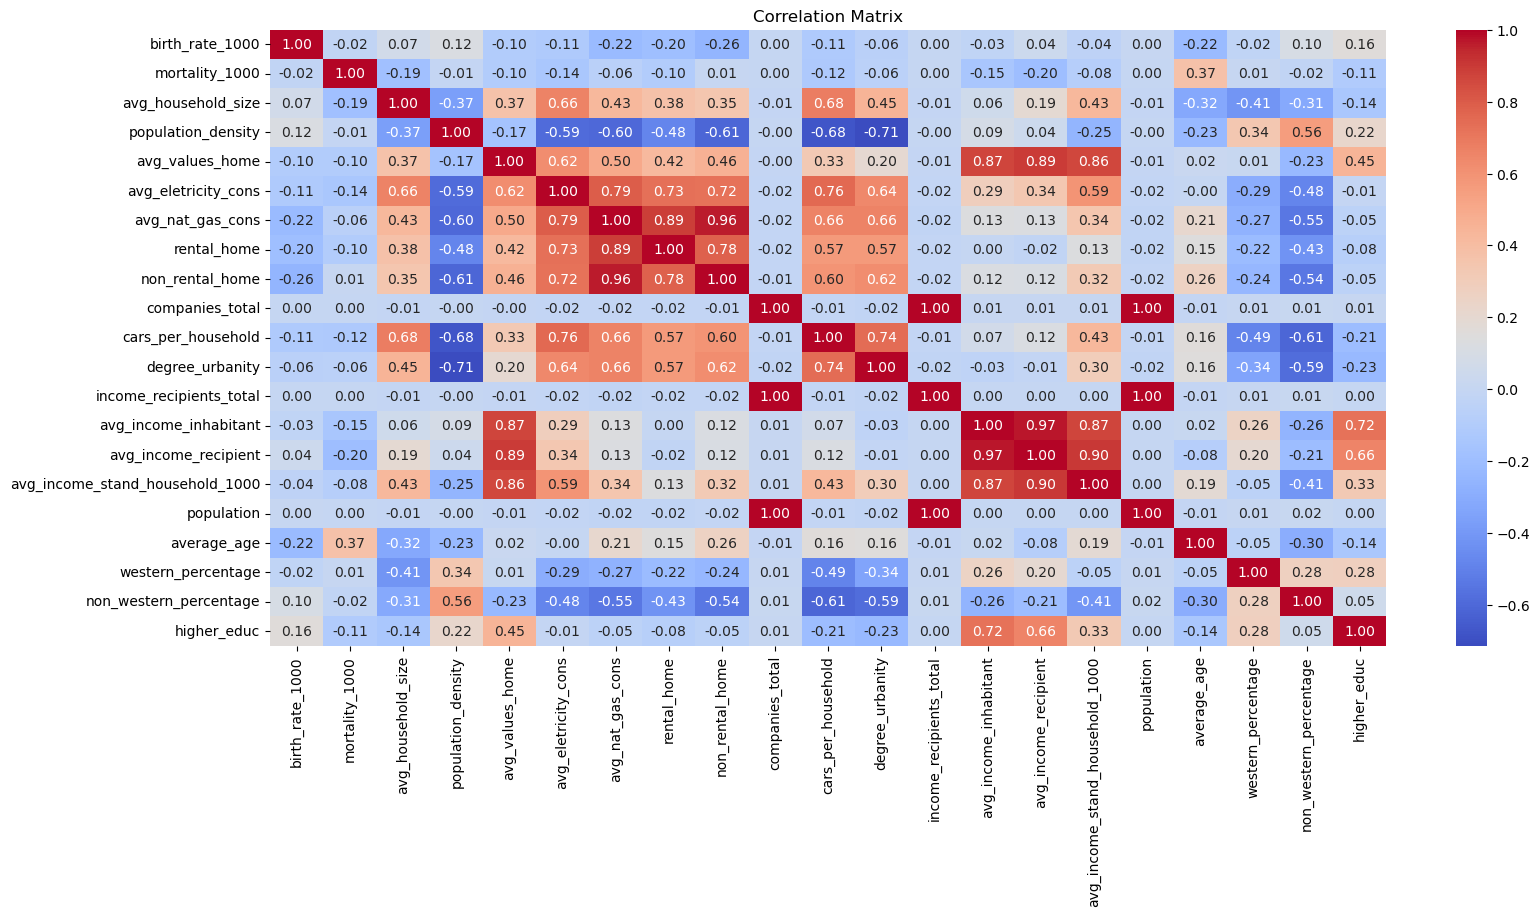

In [11]:
# calculate the correlation matrix
numeric_columns = gdf_cbs_filtered.select_dtypes(include=[np.number]).columns
correlation_matrix = gdf_cbs_filtered[numeric_columns].corr()

# create a heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [12]:
# preprocess the cbs '20 data 
rename_dict = {'Gemeentenaam_1': 'Gemeentenaam',
               'Codering_3': 'code',
               'GemiddeldInkomenPerInwoner_72': 'avg_income_inhabitant'
}

columns_to_keep = ['WijkenEnBuurten']  # columns not to be changed but included

# # rename and filter columns
gdf_cbs_filtered_20 = gdf_cbs_20.copy()
gdf_cbs_filtered_20 = gdf_cbs_filtered_20.rename(columns=rename_dict)  # rename specified columns
gdf_cbs_filtered_20 = gdf_cbs_filtered_20[list(columns_to_keep) + list(rename_dict.values())]

# the majority of income data missing, but available in cbs '20 data hence imputed below
gdf_cbs_filtered['avg_income_inhabitant'] = gdf_cbs_filtered['avg_income_inhabitant'].mask(gdf_cbs_filtered['avg_income_inhabitant'].isnull())  
gdf_cbs_filtered['avg_income_inhabitant'] = gdf_cbs_filtered['avg_income_inhabitant'].combine_first(gdf_cbs_filtered['code'].map(gdf_cbs_filtered_20.set_index('code')['avg_income_inhabitant']))
gdf_cbs_filtered.head()

WijkenEnBuurten        type  \
0                Nederland  Land         
1              Aa en Hunze  Gemeente     
2            Wijk 00 Annen  Wijk         
3                    Annen  Buurt        
4  Verspreide huizen Annen  Buurt        

                               Gemeentenaam        code  birth_rate_1000  \
0  Nederland                                 NL00                     10   
1  Aa en Hunze                               GM1680                    8   
2  Aa en Hunze                               WK168000                  9   
3  Aa en Hunze                               BU16800000               10   
4  Aa en Hunze                               BU16800009                6   

   mortality_1000  avg_household_size  population_density  avg_values_home  \
0              10                 2.1               519.0            290.0   
1              11                 2.2                92.0            273.0   
2               8                 2.3               245.0            272.0   
3               8                 2.3              1364.0            263.0   
4               6                 2.3                13.0            487.0   

   avg_eletricity_cons  ...  degree_urbanity  income_recipients_total  \
0               2810.0  ...              2.0                 13946000   
1               3160.0  ...              5.0                    20900   
2               3030.0  ...              5.0                     3000   
3               2970.0  ...              5.0                     2800   
4               4620.0  ...              5.0                      100   

   avg_income_inhabitant  avg_income_recipient  \
0                   29.2                  35.8   
1                   29.7                  35.3   
2                   30.9                  37.1   
3                   30.2                  36.4   
4                   43.1                   NaN   

   avg_income_stand_household_1000  population  average_age  \
0                             33.5    17475415    42.326804   
1                             35.1       25399    46.980098   
2                              NaN        3595    46.279555   
3                              NaN        3425    46.102190   
4                              NaN         150    51.916667   

   western_percentage  non_western_percentage  higher_educ  
0           10.636257               14.003547    24.123376  
1            4.181267                2.433167    23.504862  
2            3.337969                2.086231    24.200278  
3            3.357664                2.043796    23.941606  
4            3.333333                0.000000    33.333333  

[5 rows x 25 columns]

In [96]:
gdf_cbs_filtered['type'].value_counts()

type
Buurt         14080
Wijk           3248
Gemeente        352
Land              1
Name: count, dtype: int64

In [97]:
gdf_buurt_filtered

BU_CODE                                    BU_NAAM   WK_CODE  \
0      BU09989999                                 Buitenland  WK099899   
1      BU00109998                                        NaN  WK001099   
2      BU00349997                                        NaN  WK003499   
3      BU00509997                                        NaN  WK005099   
4      BU00569997                                        NaN  WK005699   
...           ...                                        ...       ...   
13399  BU19550205                 Verspreide huizen De Heegh  WK195502   
13400  BU19550206              Verspreide huizen Greffelkamp  WK195502   
13401  BU19550207  Verspreide huizen De Hogenend en Oud-Dijk  WK195502   
13402  BU19550208               Verspreide huizen Nieuw-Dijk  WK195502   
13403  BU19550209                     Verspreide huizen Loil  WK195502   

      GM_CODE      GM_NAAM                                           geometry  
0      GM0998   Buitenland  MULTIPOLYGON (((122416.410 383920.760, 122395....  
1      GM0010     Delfzijl  MULTIPOLYGON (((268674.309 592382.331, 268667....  
2      GM0034       Almere  MULTIPOLYGON (((150213.998 479503.726, 150087....  
3      GM0050     Zeewolde  MULTIPOLYGON (((170588.413 486792.192, 170570....  
4      GM0056     Zuidhorn  MULTIPOLYGON (((214960.238 595344.114, 215030....  
...       ...          ...                                                ...  
13399  GM1955  Montferland  POLYGON ((206718.500 440320.094, 206724.094 44...  
13400  GM1955  Montferland  POLYGON ((204831.875 442520.751, 204833.020 44...  
13401  GM1955  Montferland  POLYGON ((205483.000 439755.688, 205473.297 43...  
13402  GM1955  Montferland  POLYGON ((209695.907 440263.853, 209698.974 44...  
13403  GM1955  Montferland  POLYGON ((207290.435 443026.560, 207290.455 44...  

[13404 rows x 6 columns]

In [13]:
# check the missigness after imputation
gdf_cbs_filtered['avg_income_inhabitant'].isna().sum()

3266

In [103]:
# filter the buurt dataset with polygons to relevant column that is to be merged onto cbs 
gdf_buurt_filtered = gdf_buurt.copy()
gdf_buurt_filtered = gdf_buurt_filtered[["BU_CODE", "BU_NAAM", "WK_CODE", "GM_CODE", "GM_NAAM", "geometry"]] #filter out irrelevant features

# filter the wijk data with polygons to be merged onto cbs 
gdf_wijk_filtered = gdf_wijk.copy()
gdf_wijk_filtered = gdf_wijk_filtered[["WK_CODE", "WK_NAAM", "GM_CODE", "GM_NAAM", "geometry"]] #filter out irrelevant features

gdf_buurt_filtered.head()

BU_CODE BU_NAAM   WK_CODE GM_CODE      GM_NAAM  \
0  BU03779998     NaN  WK037799  GM0377  Bloemendaal   
1  BU08529997     NaN  WK085299  GM0852    Waterland   
2  BU07189998     NaN  WK071899  GM0718   Vlissingen   
3  BU03639997     NaN  WK036399  GM0363    Amsterdam   
4  BU06879997     NaN  WK068799  GM0687   Middelburg   

                                            geometry  
0  POLYGON ((98757.530 494793.560, 98752.831 4947...  
1  POLYGON ((136499.997 501000.739, 136866.129 50...  
2  MULTIPOLYGON (((23205.420 400019.760, 23084.51...  
3  MULTIPOLYGON (((126326.284 488278.723, 126330....  
4  POLYGON ((37669.841 395253.871, 37663.476 3952...

## Merge data

## Buurt level

In [104]:
# merge burt data w/ polygons with cbs data and aggregate them on buurt level 
merged_df = pd.merge(gdf_buurt_filtered, gdf_cbs_filtered, left_on='BU_CODE', right_on='code', how='left')
buurt_cbs_joined = gpd.GeoDataFrame(merged_df)

joined_data = gpd.sjoin(buurt_cbs_joined, vgvi, how='left', op='contains')
vgvi_by_bu = joined_data.groupby('BU_CODE')['VGVI'].mean().reset_index()

buurt_cbs_joined = buurt_cbs_joined.merge(vgvi_by_bu, on='BU_CODE', how='left')

In [106]:
# save the file
buurt_cbs_joined.to_file('data_collection/cleaned_data/buurt_cbs_joined.gpkg', driver="GPKG")

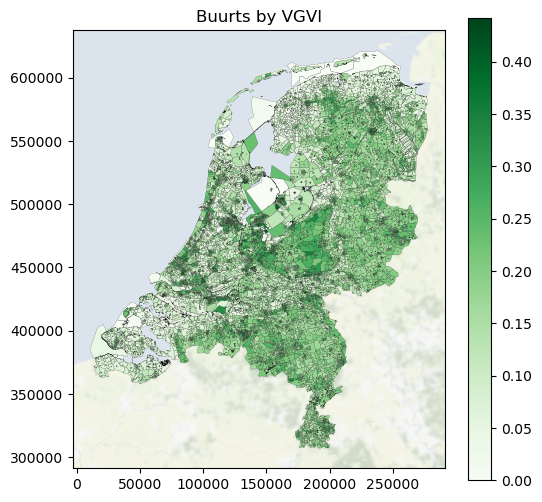

In [107]:
buurt_cbs_joined_filtered = buurt_cbs_joined[~buurt_cbs_joined['VGVI'].isnull()]
buurt_cbs_joined_filtered = buurt_cbs_joined_filtered.to_crs(epsg=28992)
fig, ax = plt.subplots(figsize=(6, 6))
buurt_cbs_joined_filtered.plot(column='VGVI', cmap='Greens', linewidth=0.1, edgecolor='black', legend=True, ax=ax)
contextily.add_basemap(ax, crs=buurt_cbs_joined_filtered.crs, source=contextily.providers.Stamen.TerrainBackground, alpha=0.35, attribution="")
plt.title('Buurts by VGVI')

plt.show()

## Wijk level

In [225]:
joined_data = gpd.sjoin(gdf_wijk_filtered, vgvi, how='left', op='contains')
vgvi_by_wijk = joined_data.groupby('WK_CODE')['VGVI'].mean().reset_index()

wijk_cbs_joined = gdf_wijk_filtered.merge(vgvi_by_wijk, on='WK_CODE', how='left')
wijk_cbs_joined

C:\Users\Ondrej\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


WK_CODE                WK_NAAM GM_CODE           GM_NAAM  \
0     WK099899             Buitenland  GM0998        Buitenland   
1     WK001099                    NaN  GM0010          Delfzijl   
2     WK003499                    NaN  GM0034            Almere   
3     WK005099                    NaN  GM0050          Zeewolde   
4     WK005699                    NaN  GM0056          Zuidhorn   
...        ...                    ...     ...               ...   
3169  WK195220              Zuidbroek  GM1952  Midden-Groningen   
3170  WK195221                 Meeden  GM1952  Midden-Groningen   
3171  WK195500  Wijk 00 's-Heerenberg  GM1955       Montferland   
3172  WK195501         Wijk 01 Brakel  GM1955       Montferland   
3173  WK195502          Wijk 02 Didam  GM1955       Montferland   

                                               geometry      VGVI  
0     MULTIPOLYGON (((122416.410 383920.760, 122395....  0.146787  
1     MULTIPOLYGON (((268674.309 592382.331, 268667....       NaN  
2     MULTIPOLYGON (((150213.998 479503.726, 150087....  0.257910  
3     MULTIPOLYGON (((170588.413 486792.192, 170570....  0.008146  
4     MULTIPOLYGON (((214960.238 595344.114, 215030....       NaN  
...                                                 ...       ...  
3169  POLYGON ((254730.907 578403.951, 254737.414 57...  0.151430  
3170  POLYGON ((256409.951 576591.951, 256416.541 57...  0.138032  
3171  POLYGON ((214858.094 434220.594, 214892.297 43...  0.143882  
3172  POLYGON ((209458.692 438018.685, 209461.472 43...  0.149558  
3173  POLYGON ((205237.879 442710.445, 205237.895 44...  0.158382  

[3174 rows x 6 columns]

C:\Users\Ondrej\.conda\envs\ssml\lib\site-packages\geopandas\geodataframe.py:1475: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


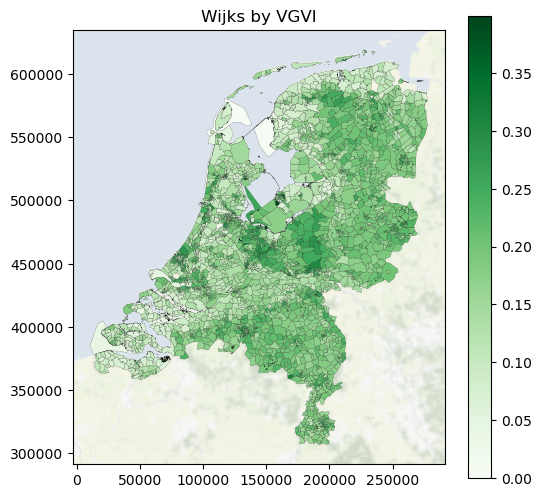

In [226]:
wijk_cbs_joined_filtered = wijk_cbs_joined[~buurt_cbs_joined['VGVI'].isnull()]
wijk_cbs_joined_filtered = wijk_cbs_joined_filtered.to_crs(epsg=28992)
fig, ax = plt.subplots(figsize=(6, 6))
wijk_cbs_joined_filtered.plot(column='VGVI', cmap='Greens', linewidth=0.1, edgecolor='black', legend=True, ax=ax)
contextily.add_basemap(ax, crs=merged_gini_df.crs, source=contextily.providers.Stamen.TerrainBackground, alpha=0.35, attribution="")
plt.title('Wijks by VGVI')

plt.show()

# Spatial autocorrelation

In [185]:
# load cleaned dataset
buurt_cbs_joined = gpd.read_file('data_collection/cleaned_data/buurt_cbs_joined.gpkg')

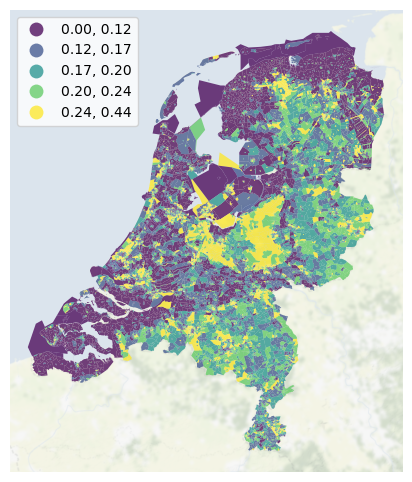

In [186]:
variable_names = [
    "VGVI",
    "geometry"
]

db = buurt_cbs_joined[variable_names].copy()
db.dropna(inplace=True) # remove rows with empty fields

f, ax = plt.subplots(1, figsize=(6, 6))
db.plot(
    column="VGVI",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)

contextily.add_basemap(ax, crs=buurt_cbs_joined.crs, source=contextily.providers.Stamen.TerrainBackground, alpha=0.35, attribution="")

ax.set_axis_off()

In [189]:
from libpysal import weights

# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"

db["VGVI_lag"] = weights.spatial_lag.lag_spatial(
    w, db["VGVI"]
)

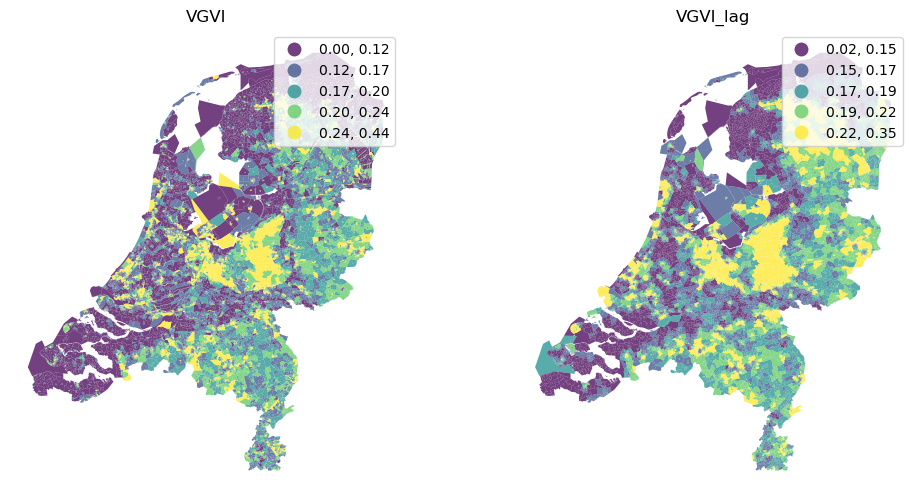

In [190]:
# create a plot for both VGVI and its lag model
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

db.plot(
    column="VGVI",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("VGVI")
contextily.add_basemap(ax, crs=db.crs, source=contextily.providers.Stamen.TerrainBackground, alpha=0.35, attribution="")

db.plot(
    column="VGVI_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("VGVI_lag")
contextily.add_basemap(ax, crs=db.crs, source=contextily.providers.Stamen.TerrainBackground, alpha=0.35, attribution="")

plt.show()

## Moran Statistic

In [191]:
db["VGVI_std"] = db["VGVI"] - db["VGVI"].mean()
db["VGVI_lag_std"] = weights.lag_spatial(
    w, db["VGVI_std"]
)

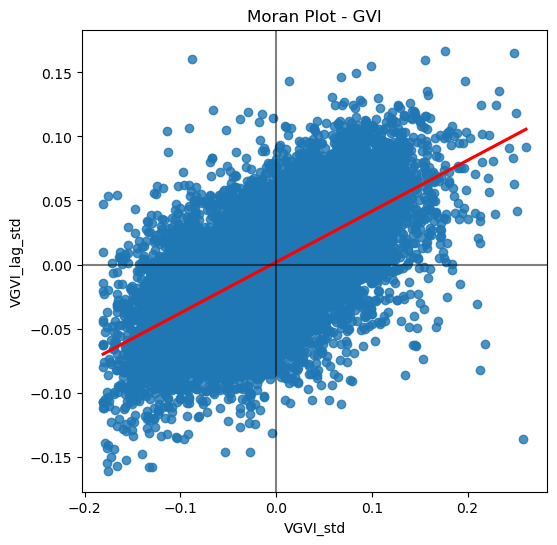

In [192]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x="VGVI_std",
    y="VGVI_lag_std",
    ci=None,
    data=db,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - GVI")
plt.show()

In [193]:
w.transform = "R"
moran = esda.moran.Moran(db["VGVI"], w)
print("Moran's I:", moran.I)
print("p-value (p-sim):", moran.p_sim)

Moran's I: 0.3976720996531423
p-value (p-sim): 0.001


## LISA

<Axes: ylabel='Density'>

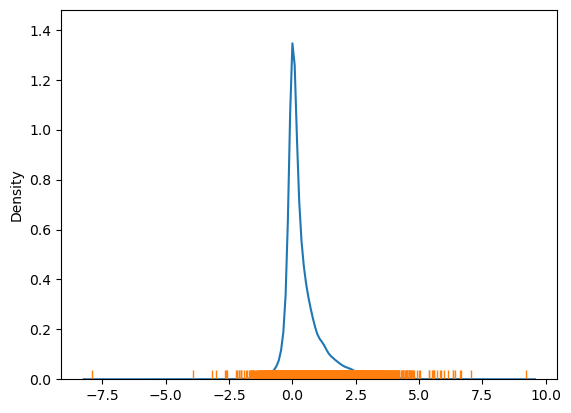

In [194]:
lisa = esda.moran.Moran_Local(db["VGVI"], w)
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax)

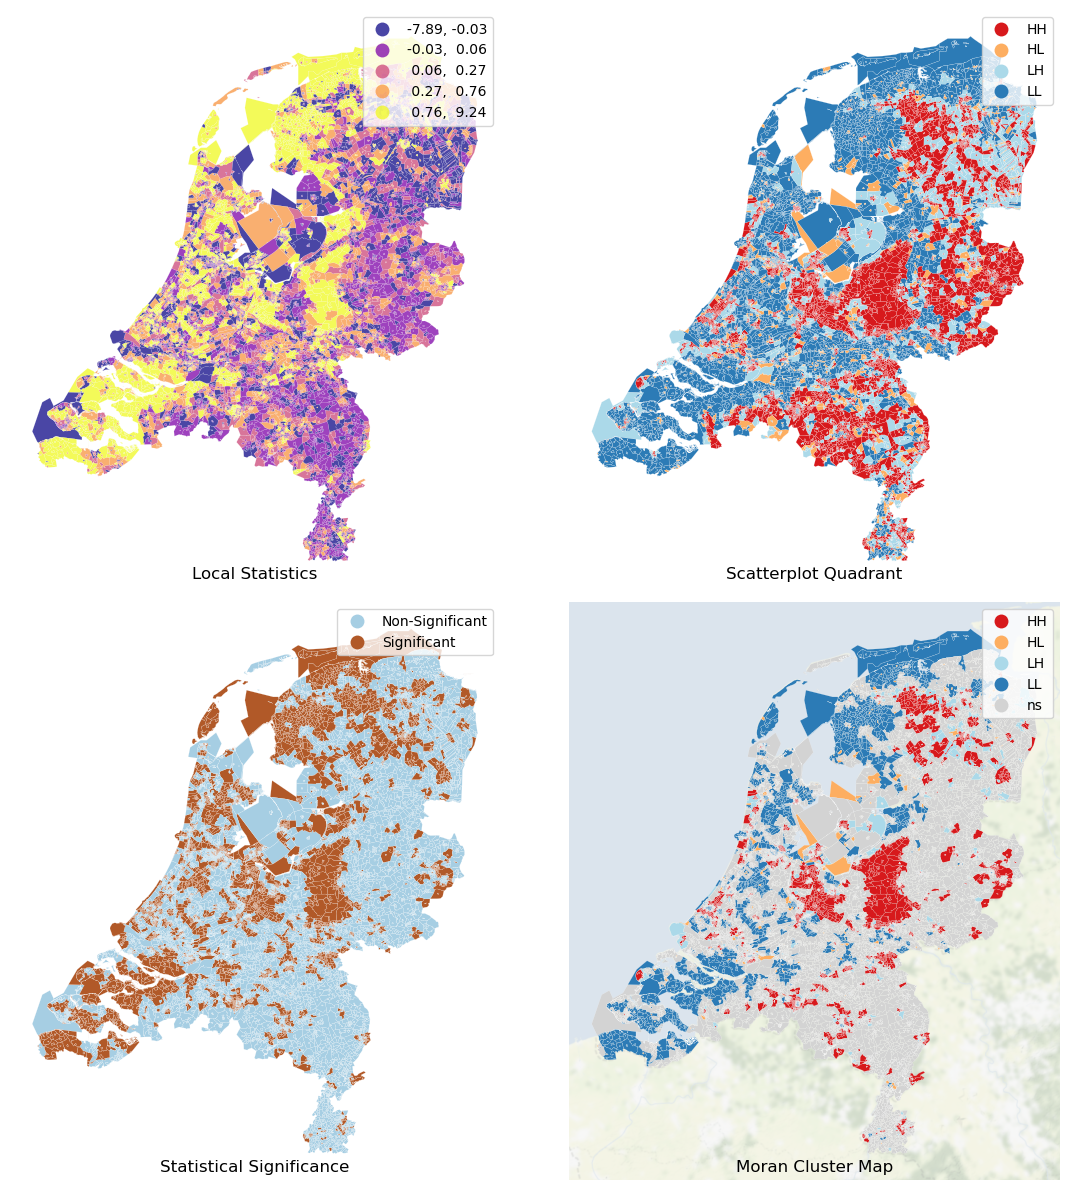

In [196]:
from splot import esda as esdaplot

# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
db.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, db, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pandas.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=db.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
db.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, db, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
contextily.add_basemap(ax, crs=db.crs, source=contextily.providers.Stamen.TerrainBackground, alpha=0.35, attribution="")
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

## GI* algorithm

In [117]:
# Gi
go_i = esda.getisord.G_Local(db["VGVI"], w)
go_i_star = esda.getisord.G_Local(db["VGVI"], w, star=True)

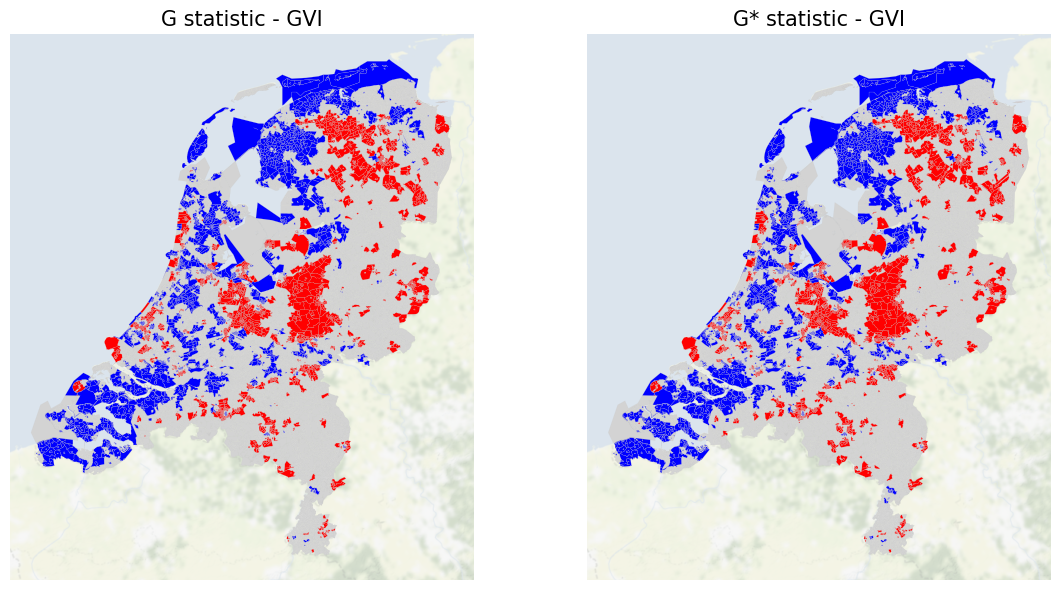

In [118]:
def g_map(g, db, ax):
    """
    Create a cluster map
    ...

    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    db     : GeoDataFrame
             Table aligned with values in `g` and containing
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    """
    ec = "0.8"

    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = db.loc[sig == False, "geometry"]
    ns.plot(ax=ax, color="lightgrey", edgecolor=ec, linewidth=0.1)
    # Plot HH clusters
    hh = db.loc[(g.Zs > 0) & (sig == True), "geometry"]
    hh.plot(ax=ax, color="red", edgecolor=ec, linewidth=0.1)
    # Plot LL clusters
    ll = db.loc[(g.Zs < 0) & (sig == True), "geometry"]
    ll.plot(ax=ax, color="blue", edgecolor=ec, linewidth=0.1)
    # Style and draw
    contextily.add_basemap(ax, crs=db.crs, source=contextily.providers.Stamen.TerrainBackground, alpha=0.35, attribution="")
    # Flag to add a star to the title if it's G_i*
    st = ""
    if g.star:
        st = "*"
    # Add title
    ax.set_title(f"G{st} statistic - GVI", size=15)
    # Remove axis for aesthetics
    ax.set_axis_off()
    return ax

# Set up figure and axes
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Loop over the two statistics
for g, ax in zip([go_i, go_i_star], axs.flatten()):
    # Generate the statistic's map
    ax = g_map(g, db, ax)
# Tight layout to minimise blank spaces
f.tight_layout()
# Render
plt.show()

# GWR 

In [40]:
import numpy as np
import pandas as pd
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl

In [119]:
# load cleaned dataset
buurt_cbs_joined = gpd.read_file('data_collection/cleaned_data/buurt_cbs_joined.gpkg')

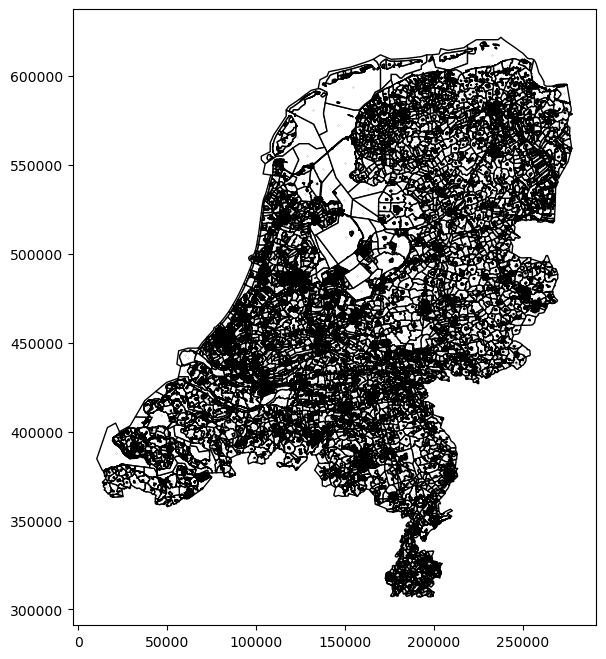

In [120]:
fig, ax = plt.subplots(figsize = (8, 8))
buurt_cbs_joined.plot(ax=ax, **{'edgecolor': 'black', 'facecolor': 'white'})
buurt_cbs_joined.centroid.plot(ax = ax, c = 'black', markersize=1/100)
plt.show()

In [121]:
buurt_cbs_joined.columns

Index(['BU_CODE', 'BU_NAAM', 'WK_CODE', 'GM_CODE', 'GM_NAAM',
       'WijkenEnBuurten', 'type', 'Gemeentenaam', 'code', 'birth_rate_1000',
       'mortality_1000', 'avg_household_size', 'population_density',
       'avg_values_home', 'avg_eletricity_cons', 'avg_nat_gas_cons',
       'rental_home', 'non_rental_home', 'companies_total',
       'cars_per_household', 'degree_urbanity', 'income_recipients_total',
       'avg_income_inhabitant', 'avg_income_recipient',
       'avg_income_stand_household_1000', 'population', 'average_age',
       'western_percentage', 'non_western_percentage', 'higher_educ', 'VGVI',
       'geometry'],
      dtype='object')

In [122]:
# perform OLS first to get an idea of the data
# Define the variable names to filter
variable_names = [
    "avg_income_inhabitant",
    "higher_educ",
    "average_age",
    "non_western_percentage",
    "avg_values_home",
    "VGVI",
    "geometry"
]


filtered_gdf = buurt_cbs_joined.copy()
filtered_gdf = filtered_gdf[variable_names]
filtered_gdf.dropna(inplace=True)
filtered_gdf.reset_index(drop=True, inplace=True)
filtered_gdf.head()

avg_income_inhabitant  higher_educ  average_age  non_western_percentage  \
0                   22.1    41.509434    31.958935               10.432852   
1                   32.8    27.272727    40.113636                9.090909   
2                   28.0    16.438356    41.575342                1.369863   
3                   26.2    18.181818    45.347594                4.278075   
4                   22.8    25.000000    37.315341               10.227273   

   avg_values_home      VGVI  \
0            222.0  0.097535   
1            306.0  0.070101   
2            382.0  0.079614   
3            250.0  0.225145   
4            197.0  0.111380   

                                            geometry  
0  POLYGON ((233836.216 582380.178, 233892.194 58...  
1  POLYGON ((41705.501 393496.029, 41711.064 3934...  
2  POLYGON ((203761.286 511735.946, 203789.135 51...  
3  POLYGON ((209339.203 447081.813, 209266.703 44...  
4  POLYGON ((132946.978 396009.529, 132947.712 39...

In [123]:
variable_names = [
    "avg_income_inhabitant",
    "higher_educ",
    "average_age",
    "non_western_percentage",
    "avg_values_home"
]

db = filtered_gdf.copy()
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    db[["VGVI"]].values,
    # Independent variables
    db[variable_names].values,
    # Dependent variable name
    name_y="VGVI",
    # Independent variable name
    name_x=variable_names,
)
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :        VGVI                Number of Observations:       10223
Mean dependent var  :      0.1839                Number of Variables   :           6
S.D. dependent var  :      0.0597                Degrees of Freedom    :       10217
R-squared           :      0.0897
Adjusted R-squared  :      0.0893
Sum squared residual:      33.135                F-statistic           :    201.4530
Sigma-square        :       0.003                Prob(F-statistic)     :  1.848e-205
S.E. of regression  :       0.057                Log likelihood        :   14792.287
Sigma-square ML     :       0.003                Akaike info criterion :  -29572.573
S.E of regression ML:      0.0569                Schwarz criterion     :  -29529.179

-----------------------------------------------------------------------------

## GWR - Adaptive kernel

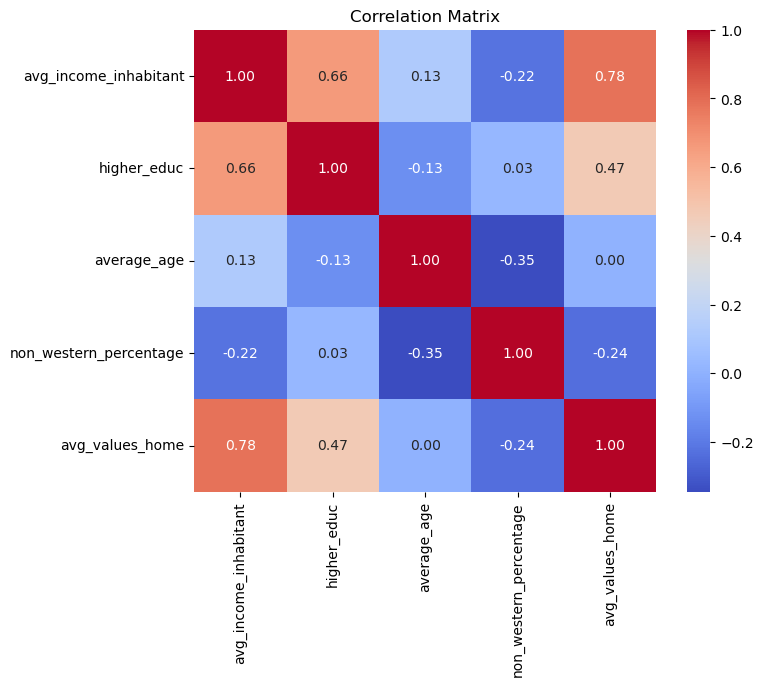

In [124]:
variable_names = [
    "avg_income_inhabitant",
    "higher_educ",
    "average_age",
    "non_western_percentage",
    "avg_values_home"
]


correlation_matrix = filtered_gdf[variable_names].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()

In [125]:
variable_names = [
    "avg_income_inhabitant",
    "higher_educ",
    "average_age",
    "non_western_percentage",
    "avg_values_home"
]

g_y = filtered_gdf['VGVI'].values.reshape((-1, 1)).astype(float)
g_X = filtered_gdf[variable_names].values.astype(float)

u = filtered_gdf['geometry'].centroid.x
v = filtered_gdf['geometry'].centroid.y

g_X = (g_X - g_X.mean(axis = 0)) / g_X.std(axis = 0)
g_y = g_y.reshape((-1,1))
g_y = (g_y - g_y.mean(axis = 0)) / g_y.std(axis = 0)

g_coords = list(zip(u, v))

bw = Sel_BW(g_coords, g_y, g_X).search(criterion='AICc')
np.float = float # avoid numpy updata issue with floats 
gwr_results = GWR(g_coords, g_y, g_X, bw, fixed = False).fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                               10223
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           9305.588
Log-likelihood:                                                  -14025.200
AIC:                                                              28062.400
AICc:                                                             28064.411
BIC:                                                             -85021.795
R2:                                                                   0.090
Adj. R2:                                                              0.089

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

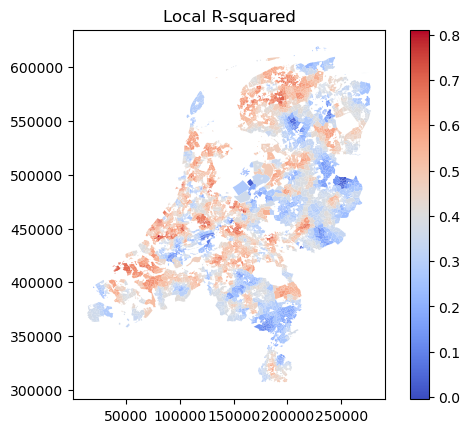

In [126]:
# plot the local R2 
local_r2 = gwr_results.localR2
filtered_gdf['local_r2'] = local_r2
filtered_gdf.plot(column='local_r2', cmap='coolwarm', legend=True)
plt.title('Local R-squared')
plt.show()

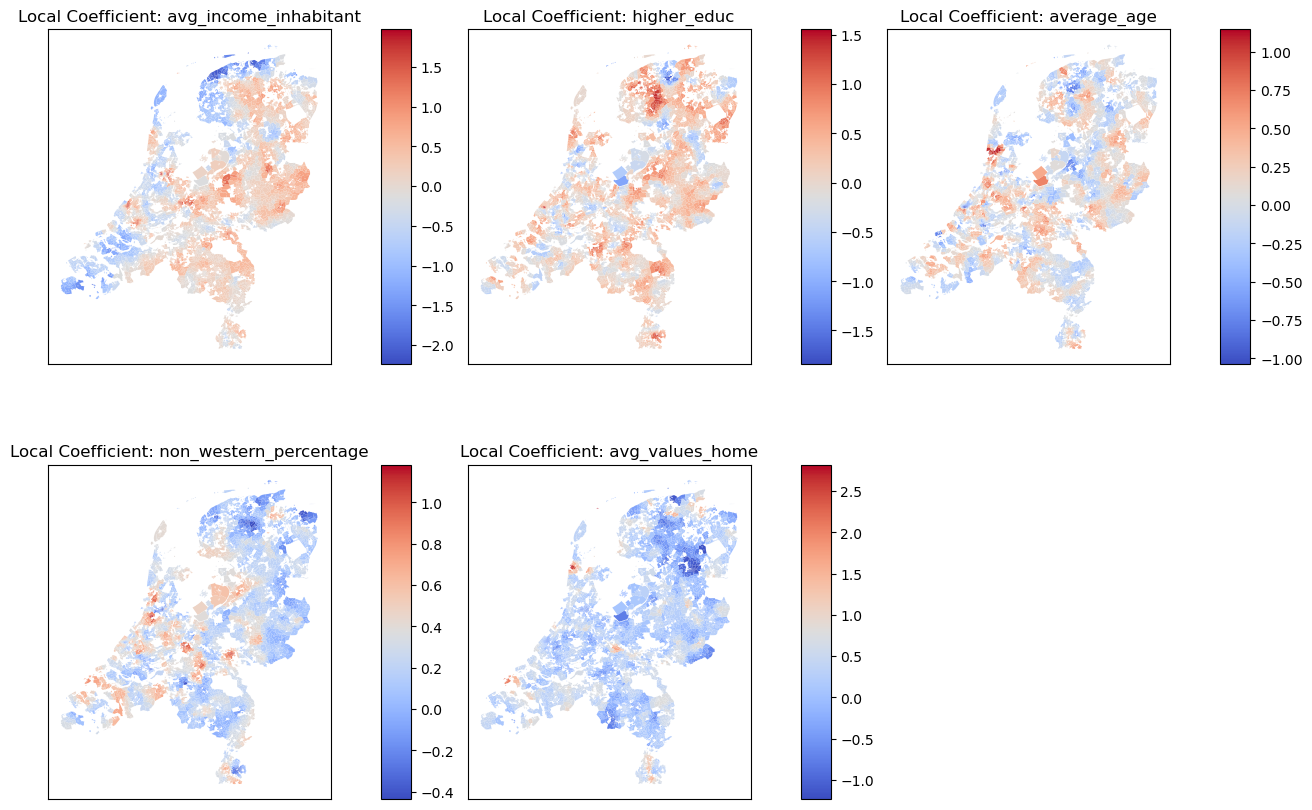

In [127]:
import math

# Determine the number of rows and columns based on the number of variables
num_variables = len(variable_names)
num_rows = 2
num_cols = math.ceil(num_variables / num_rows)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Adjust the spacing between subplots and colorbars
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Flatten the axs array
axs = axs.flatten()

for i, coef_variable in enumerate(variable_names):
    local_coefficients = gwr_results.params[:, i]  # extract the local coefficients

    filtered_gdf['local_coefficients'] = local_coefficients
    
    # Calculate the subplot index based on the current row and column
    subplot_index = i % (num_rows * num_cols)
    ax = axs[subplot_index]
    ax.set_title('Local Coefficient: {}'.format(coef_variable))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Plot the choropleth
    filtered_gdf.plot(column='local_coefficients', cmap='coolwarm', legend=True, cax=fig.add_axes([ax.get_position().x1 + 0.02, ax.get_position().y0, 0.02, ax.get_position().height]), ax=ax)

    # Hide any remaining empty subplots
for j in range(num_variables, num_rows * num_cols):
    axs[j].axis('off')

plt.show()

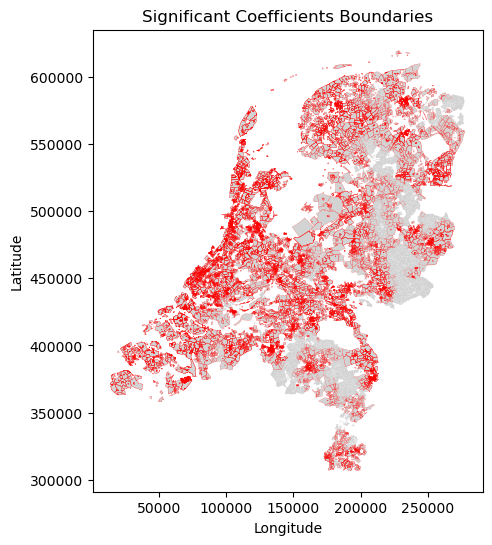

In [128]:
import matplotlib.pyplot as plt

# get the t-values from GWR results
t_values = gwr_results.tvalues
is_significant = (t_values < -1.96) | (t_values > 1.96)  # Significance level at 95%

# plot the significant coefficients with boundaries and no fill
fig, ax = plt.subplots(figsize=(6, 6))
filtered_gdf.plot(color='lightgray', ax=ax)  
filtered_gdf[is_significant].boundary.plot(color='red', linewidth=1/10, ax=ax)  # Plot only boundaries of significant coefficients

# plot the non-significant coefficients with no boundaries and no fill
filtered_gdf[~is_significant].plot(facecolor='none', edgecolor='none', ax=ax)

ax.set_title('Significant Coefficients Boundaries')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# MGWR 
## (pysal/mgwr - slow computation won't run if observations > 5000)

In [237]:
# Using mgwr from a standard package, too slow, use the second approach below
variable_names = [
    "avg_income_inhabitant",
    "higher_educ",
    "average_age",
    "non_western_percentage",
    "avg_values_home"
]

g_y = filtered_gdf['VGVI'].values.reshape((-1, 1)).astype(float)
g_X = filtered_gdf[variable_names].values.astype(float)

u = filtered_gdf['geometry'].centroid.x
v = filtered_gdf['geometry'].centroid.y

g_X = (g_X - g_X.mean(axis = 0)) / g_X.std(axis = 0)
g_y = g_y.reshape((-1,1))
g_y = (g_y - g_y.mean(axis = 0)) / g_y.std(axis = 0)

g_coords = list(zip(u, v))

mgwr_selector = Sel_BW(g_coords, g_y, g_X, multi = True).search(criterion='AICc')
mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()
mgwr_results

## (fastMGWR - fast computation)
https://github.com/Ziqi-Li/FastGWR

In [64]:
# first we preprocess the data into the required format for fastMGWR
variable_names = [
    "avg_income_inhabitant",
    "higher_educ",
    "average_age",
    "non_western_percentage",
    "avg_values_home"
]

g_y = filtered_gdf['VGVI'].values.reshape((-1, 1)).astype(float)
g_X = filtered_gdf[variable_names].values.astype(float)
u = filtered_gdf['geometry'].centroid.x
v = filtered_gdf['geometry'].centroid.y

# create a new df to store the data
mgwr_input = pd.DataFrame({
    "X-coord": u,
    "y-coord": v,
    "y": g_y.flatten()
})

# add the features to the df
for i, var_name in enumerate(variable_names):
    mgwr_input[var_name] = g_X[:, i]

# save 
mgwr_input.to_csv('input_mgwr.csv', index=False)

In [65]:
mgwr_input.head()

X-coord        y-coord         y  avg_income_inhabitant  higher_educ  \
0  233655.736037  582070.787490  0.097535                   22.1    41.509434   
1  233834.593724  581588.756129  0.133514                   22.7    45.709828   
2  234292.167225  582097.290691  0.154336                   21.5    44.124700   
3  233195.739462  581682.520840  0.133627                   24.8    45.481050   
4  233458.531927  582523.151874  0.141828                   26.9    45.535714   

   average_age  non_western_percentage  avg_values_home  
0    31.958935               10.432852            222.0  
1    32.583853               11.778471            225.0  
2    33.603118               14.388489            191.0  
3    34.569971                9.620991            226.0  
4    35.232143               10.892857            224.0

In [3]:
# run from anaconda prompt for faster implementation 
!fastgwr run -np 4 -data input_mgwr.csv -mgwr - chunks 10

!tested only on 1000 observations for now

In [4]:
# load the results 
fastmgwr_output = pd.read_csv('fastmgwr_rslt.csv')
fastmgwr_output

index  residual  b_intercept  b_avg_income_inhabitant  b_higher_educ  \
0      0.0 -1.145136    -0.775141                -0.102779       0.230766   
1      1.0 -0.636075    -0.798735                -0.101320       0.234109   
2      2.0 -0.406729    -0.778501                -0.103024       0.228339   
3      3.0 -0.735055    -0.724706                -0.101455       0.234667   
4      4.0 -0.673171    -0.685086                -0.104037       0.240416   
..     ...       ...          ...                      ...            ...   
995  995.0 -0.627674     0.440151                 0.255735       0.275371   
996  996.0 -0.973858     0.434679                 0.254067       0.279613   
997  997.0 -0.641438     0.435715                 0.252801       0.285657   
998  998.0  0.909833     0.449189                 0.258973       0.265951   
999  999.0 -0.175913     0.384020                 0.153278       0.304224   

     b_average_age  b_western_percentage  b_non_western_percentage  \
0         0.303933              0.059304                  0.318016   
1         0.303713              0.059351                  0.317554   
2         0.304556              0.059352                  0.318344   
3         0.302276              0.059295                  0.317052   
4         0.304095              0.059258                  0.318415   
..             ...                   ...                       ...   
995       0.109106              0.071695                  0.104658   
996       0.107270              0.071686                  0.104635   
997       0.110425              0.071672                  0.104498   
998       0.108957              0.071720                  0.104775   
999       0.150325              0.071318                  0.102540   

     se_intercept  se_avg_income_inhabitant  se_higher_educ  se_average_age  \
0        0.329950                  0.113370        0.156117        0.072095   
1        0.325522                  0.113318        0.158356        0.072129   
2        0.323295                  0.113346        0.158838        0.072208   
3        0.329428                  0.113367        0.154888        0.071884   
4        0.328365                  0.113419        0.154708        0.072057   
..            ...                       ...             ...             ...   
995      0.170999                  0.164259        0.276666        0.081228   
996      0.170352                  0.165821        0.276667        0.081832   
997      0.170218                  0.165688        0.278777        0.081121   
998      0.172239                  0.162724        0.276648        0.081808   
999      0.164908                  0.160006        0.253761        0.075450   

     se_western_percentage  se_non_western_percentage  
0                 0.044332                   0.088765  
1                 0.044316                   0.088966  
2                 0.044316                   0.088933  
3                 0.044334                   0.088619  
4                 0.044347                   0.088565  
..                     ...                        ...  
995               0.040662                   0.063301  
996               0.040663                   0.063325  
997               0.040658                   0.063305  
998               0.040664                   0.063276  
999               0.040610                   0.063134  

[1000 rows x 14 columns]

In [5]:
# <!-- Computing Inference with 5 Chunk(s)
# Diagnostic Information
# AICc 2570.06322720765
# ENP [54.82408911 17.87087292 35.38034269  8.21875285  1.53043685  3.27840121]
# R2 0.42091289697939016
# Total Time Elapsed 280.87 seconds -->

# Tree inequality using GINI index

In [ ]:
gdf_gini = joined_data.copy()
gdf_gini.head()

## Non-weighted Gini index

In [130]:
import numpy as np
import pandas as pd

def gini(x):
    """the function calculates a gini_index taking
    one dimensional input""" 
    n = len(x)
    mean_val = np.mean(x)
    diff_sum = np.sum(np.abs(np.subtract.outer(x, x)))
    gini_index = diff_sum / (2 * n * n * mean_val)
    return gini_index

# group by 'BU_CODE' and calculate Gini
gini_indices = []
for buurt, group in gdf_gini.groupby('BU_CODE'):
    vgvi_values = group['VGVI'].values
    gini_index = gini(vgvi_values)
    gini_indices.append({'buurt': buurt, 'gini_index': gini_index})

gini_df = pd.DataFrame(gini_indices)
merged_gini_df = gdf_buurt_filtered.merge(gini_df, left_on='BU_CODE', right_on='buurt', how='left')
merged_gini_df

BU_CODE                                      BU_NAAM   WK_CODE  \
0      BU03779998                                          NaN  WK037799   
1      BU08529997                                          NaN  WK085299   
2      BU07189998                                          NaN  WK071899   
3      BU03639997                                          NaN  WK036399   
4      BU06879997                                          NaN  WK068799   
...           ...                                          ...       ...   
14407  BU04310000                                    Kerkbuurt  WK043100   
14408  BU17110102                                  In de Mehre  WK171101   
14409  BU03631200                              Houthavens West  WK036312   
14410  BU01935050                         Oldenelerlanden-West  WK019350   
14411  BU08200009  Verspreide huizen ten zuidoosten van Nuenen  WK082000   

      GM_CODE                        GM_NAAM  \
0      GM0377                    Bloemendaal   
1      GM0852                      Waterland   
2      GM0718                     Vlissingen   
3      GM0363                      Amsterdam   
4      GM0687                     Middelburg   
...       ...                            ...   
14407  GM0431                       Oostzaan   
14408  GM1711                  Echt-Susteren   
14409  GM0363                      Amsterdam   
14410  GM0193                         Zwolle   
14411  GM0820  Nuenen, Gerwen en Nederwetten   

                                                geometry       buurt  \
0      POLYGON ((98757.530 494793.560, 98752.831 4947...  BU03779998   
1      POLYGON ((136499.997 501000.739, 136866.129 50...  BU08529997   
2      MULTIPOLYGON (((23205.420 400019.760, 23084.51...  BU07189998   
3      MULTIPOLYGON (((126326.284 488278.723, 126330....  BU03639997   
4      POLYGON ((37669.841 395253.871, 37663.476 3952...  BU06879997   
...                                                  ...         ...   
14407  POLYGON ((121547.325 495883.213, 121552.235 49...  BU04310000   
14408  POLYGON ((187994.239 341465.375, 187994.661 34...  BU17110102   
14409  POLYGON ((121142.831 489957.095, 121263.286 48...  BU03631200   
14410  POLYGON ((203070.771 500431.690, 203071.348 50...  BU01935050   
14411  POLYGON ((168798.695 387819.565, 168803.341 38...  BU08200009   

       gini_index  
0             NaN  
1             NaN  
2        0.166757  
3             NaN  
4             NaN  
...           ...  
14407    0.321478  
14408    0.353502  
14409    0.447823  
14410    0.277528  
14411    0.217527  

[14412 rows x 8 columns]

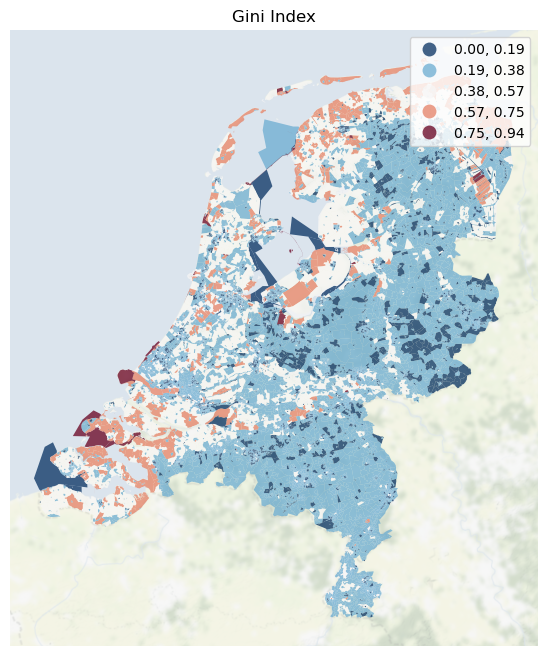

In [131]:
import matplotlib.pyplot as plt
import contextily
from pysal.lib import weights

fig, ax = plt.subplots(figsize=(8, 8))

cmap = plt.cm.RdBu.reversed()
merged_gini_df.plot(column="gini_index", cmap=cmap, scheme="equal_interval", k = 5, edgecolor="white", linewidth=0.0, alpha=0.75, legend=True, ax=ax)
contextily.add_basemap(ax, crs=merged_gini_df.crs, source=contextily.providers.Stamen.TerrainBackground, alpha=0.35, attribution="")

ax.set_axis_off()
ax.set_title("Gini Index")

# Show the plot
plt.show()

## Weighted Gini index by population

In [136]:
def weighted_gini(x, w):
    # Convert input arrays to numpy arrays
    x = np.asarray(x)
    w = np.asarray(w)
    
    # Sort x and w in ascending order of x
    sorted_indices = np.argsort(x)
    sorted_x = x[sorted_indices]
    sorted_w = w[sorted_indices]
    
    # Calculate cumulative sums
    cumw = np.cumsum(sorted_w, dtype=float)
    cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
    
    # Calculate the weighted Gini index
    weighted_gini_index = (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) /
                           (cumxw[-1] * cumw[-1]))
    
    return weighted_gini_index

gini_indices = []
for buurt, group in gdf_gini.groupby('BU_CODE'):
    vgvi_values = group['VGVI'].values
    population_weights = group['population'].values
    gini_index = weighted_gini(vgvi_values, population_weights)
    gini_indices.append({'buurt': buurt, 'gini_index': gini_index})

gini_df = pd.DataFrame(gini_indices)
merged_w_gini_df = buurt_cbs_joined.merge(gini_df, left_on='BU_CODE', right_on='buurt', how='left')
merged_w_gini_df.head()

BU_CODE BU_NAAM   WK_CODE GM_CODE      GM_NAAM WijkenEnBuurten type  \
0  BU03779998     NaN  WK037799  GM0377  Bloemendaal             NaN  NaN   
1  BU08529997     NaN  WK085299  GM0852    Waterland             NaN  NaN   
2  BU07189998     NaN  WK071899  GM0718   Vlissingen             NaN  NaN   
3  BU03639997     NaN  WK036399  GM0363    Amsterdam             NaN  NaN   
4  BU06879997     NaN  WK068799  GM0687   Middelburg             NaN  NaN   

  Gemeentenaam code  birth_rate_1000  ...  avg_income_stand_household_1000  \
0          NaN  NaN              NaN  ...                              NaN   
1          NaN  NaN              NaN  ...                              NaN   
2          NaN  NaN              NaN  ...                              NaN   
3          NaN  NaN              NaN  ...                              NaN   
4          NaN  NaN              NaN  ...                              NaN   

   population  average_age  western_percentage  non_western_percentage  \
0         NaN          NaN                 NaN                     NaN   
1         NaN          NaN                 NaN                     NaN   
2         NaN          NaN                 NaN                     NaN   
3         NaN          NaN                 NaN                     NaN   
4         NaN          NaN                 NaN                     NaN   

   higher_educ      VGVI                                           geometry  \
0          NaN       NaN  POLYGON ((98757.530 494793.560, 98752.831 4947...   
1          NaN       NaN  POLYGON ((136499.997 501000.739, 136866.129 50...   
2          NaN  0.042969  MULTIPOLYGON (((23205.420 400019.760, 23084.51...   
3          NaN       NaN  MULTIPOLYGON (((126326.284 488278.723, 126330....   
4          NaN       NaN  POLYGON ((37669.841 395253.871, 37663.476 3952...   

        buurt  gini_index  
0  BU03779998         NaN  
1  BU08529997         NaN  
2  BU07189998         NaN  
3  BU03639997         NaN  
4  BU06879997         NaN  

[5 rows x 34 columns]

In [199]:
summary_stats = merged_w_gini_df['gini_index'].describe()

# create the summary DataFrame
summary_df = pd.DataFrame({
    "Statistic": ["Count", "Mean", "Standard Deviation", "Minimum", "25th Percentile",
                   "50th Percentile (Median)", "75th Percentile", "Maximum"],
    "Value": summary_stats.round(2)
})

summary_df = summary_df.set_index('Statistic', drop=True)
summary_df

Value
Statistic                         
Count                     13296.00
Mean                          0.28
Standard Deviation            0.12
Minimum                      -0.00
25th Percentile               0.20
50th Percentile (Median)      0.25
75th Percentile               0.33
Maximum                       0.93

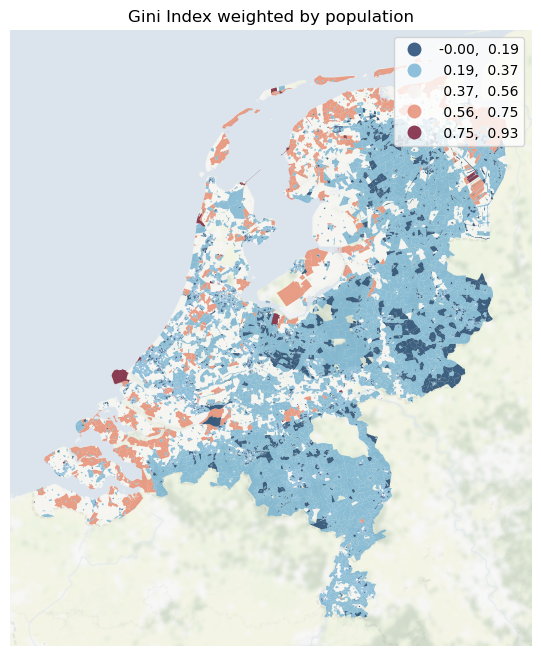

In [137]:
import matplotlib.pyplot as plt
import contextily
from pysal.lib import weights

fig, ax = plt.subplots(figsize=(8, 8))

cmap = plt.cm.RdBu.reversed()
merged_w_gini_df.plot(column="gini_index", cmap=cmap, scheme="equal_interval", k = 5, edgecolor="white", linewidth=0.0, alpha=0.75, legend=True, ax=ax)
contextily.add_basemap(ax, crs=merged_w_gini_df.crs, source=contextily.providers.Stamen.TerrainBackground, alpha=0.35, attribution="")

ax.set_axis_off()
ax.set_title("Gini Index weighted by population")

# Show the plot
plt.show()